In [34]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

Original image shape: (640, 428)


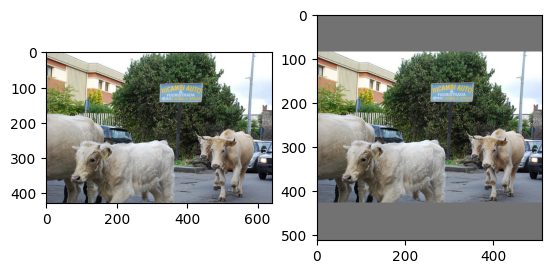

In [35]:
image = Image.open("./images/image.jpg")
print(f"Original image shape: {image.size}")
H, W = (512, 512)
ori_w, ori_h = image.size
scale = min(H/ori_h, W/ori_w)
new_h, new_w = int(scale*ori_h), int(scale*ori_w)

dw, dh = max(W - new_w, 0), max(H - new_h, 0)
left = dw // 2
right = dw - left
top = dh // 2
bottom = dh - top
# input_tensor = torch.as_tensor(image).permute(2, 0, 1).unsqueeze(0).float()

trf = T.Compose([
    T.Resize((new_h, new_w), interpolation=T.InterpolationMode.LANCZOS),  # 保持比例的缩放
    T.Pad((left, top, right, bottom), fill=(114, 114, 114)),  # 对称填充
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocessed_image = trf(image)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.show()


In [36]:
# from torchvision.models.resnet import ResNet50_Weights, ResNet101_Weights
# from torchvision.models.convnext import ConvNeXt_Tiny_Weights
torch.hub.set_dir('./')
input_tensor = T.ToTensor()(preprocessed_image).unsqueeze(0)
print(f"Input shape: {input_tensor.shape}")
resnet50 = torchvision.models.resnet50(pretrained=True)
# convnext = torchvision.models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)


input_layer = nn.Sequential(resnet50.conv1, resnet50.bn1, resnet50.relu, resnet50.maxpool)
resnet50.eval()

c1 = input_layer(input_tensor)
c2 = resnet50.layer1(c1)
c3 = resnet50.layer2(c2)
c4 = resnet50.layer3(c3)
c5 = resnet50.layer4(c4)
print(f"C1 shape: {c1.shape}")
print(f"C2 shape: {c2.shape}")
print(f"C3 shape: {c3.shape}")
print(f"C4 shape: {c4.shape}")
print(f"C5 shape: {c5.shape}")


Input shape: torch.Size([1, 3, 512, 512])


C1 shape: torch.Size([1, 64, 128, 128])
C2 shape: torch.Size([1, 256, 128, 128])
C3 shape: torch.Size([1, 512, 64, 64])
C4 shape: torch.Size([1, 1024, 32, 32])
C5 shape: torch.Size([1, 2048, 16, 16])


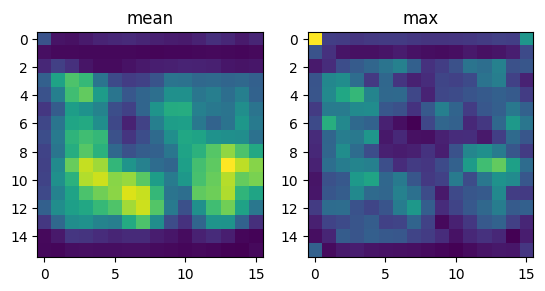

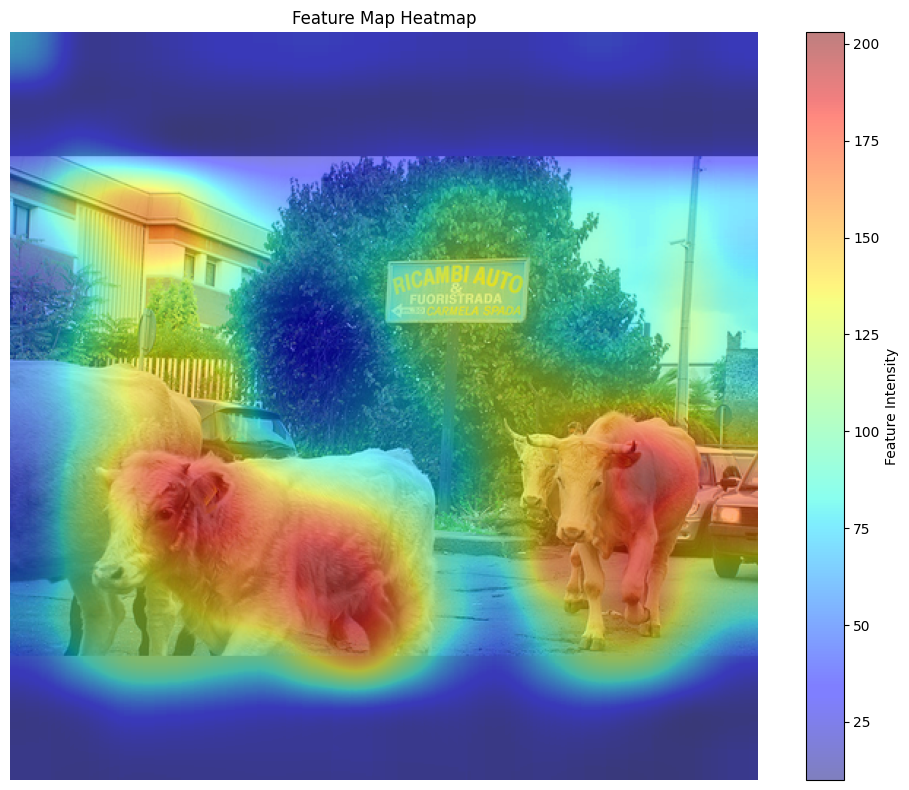

In [37]:
from mmdetection.hooks.tools import show_heatmap
selected_feat = c5
fig, axes = plt.subplots(1, 2)
axes[0].set_title('mean')
axes[0].imshow(selected_feat.squeeze(0).permute(1, 2, 0).detach().cpu().numpy().mean(axis=-1))
axes[1].set_title('max')
axes[1].imshow(selected_feat.squeeze(0).permute(1, 2, 0).detach().cpu().numpy().max(axis=-1))
plt.show()

show_heatmap(
    image=preprocessed_image, 
    feature_map=selected_feat,
    alpha=0.5,
    cmap='jet')

In [26]:
import torch
import torch.nn as nn
from mmengine.config import Config
from mmengine.runner import Runner
import sys
import os.path as osp
from pathlib import Path
config = Path('configs/efficientdet_effb0_bifpn_8xb16-crop512-300e_coco-algae.py')
cfg = Config.fromfile(config)
# cfg.work_dir = osp.join('./work_dirs', config.stem)
# runner = Runner.from_cfg(cfg)
model_cfg = cfg.model

In [29]:
from mmengine.registry import MODELS
# from mmdet.registry import MODELS as MMDET_MODELS
backbone_cfg = model_cfg.backbone
backbone_cfg.update(dict(init_cfg=None))
backbone = MODELS.build(backbone_cfg)

In [31]:
# Print model structure to a file in root directory
with open('eff_backbone.txt', 'w') as f:
    print(backbone, file=f)


torch.Size([1, 3, 768, 768])
ndarry (768, 768, 3)


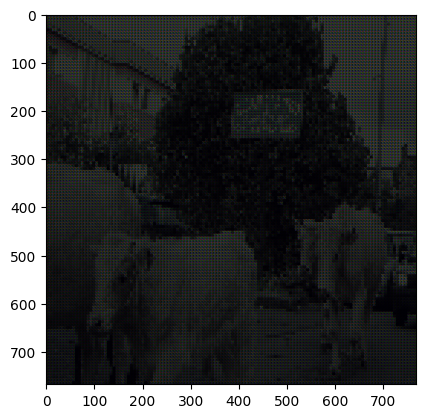

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from mmdetection.model.asat import FeedForwardAmplifier
torch.manual_seed(913)
import cv2
from cv2 import imread, resize
image = imread("images/image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = resize(image, (128, 128), interpolation=cv2.INTER_LINEAR)
image = image.transpose(2, 0, 1)
image = image.astype(np.float32)
image = torch.from_numpy(image)
x = image.unsqueeze(0)

ffa = FeedForwardAmplifier(
    in_channels=3,
    hidden_channels=24,
    out_channels=3,
    upsample_factor=6
)
upsample = nn.Sequential(
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
)
out = ffa(x)
print(out.shape)
# use matplotlib to show the image
import matplotlib.pyplot as plt
res = out.squeeze(0).permute(1, 2, 0)
res = res.detach().numpy()
print(f"ndarry {res.shape}")
res = (res - res.min()) / (res.max() - res.min())
plt.imshow(res)

In [ ]:
out.squeeze(0).mean(0, keepdims=True).permute(1,2,0)

torch.Size([1, 512, 512])